# Отток клиентов

Прогноз оттока клиентов. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## План работы 

1. Загрузка и подготовка данных. 
    * Проверка на пропуски / дубликаты
    * OHE
    * Разделение
    * Масштабирование
2. Исследование баланса классов. 
    * Обучение модели без учёта дисбаланса
    * Выводы
3. Улучшение качества модели.
    * Учесть и исправить дисбаланс
    * Обучить разные модели и выбрать лучшую 
    * Выводы
4. Финальное тестирование
5. Вывод

# 1. Загрузка и подготовка данных.

Для начала импортируем библиотеку Pandas для работы с таблицей и посмотрим первые 15 строк. 

In [1]:
import pandas as pd 
df = pd.read_csv("/datasets/Churn.csv", index_col='RowNumber')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [2]:
df.head(15)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0


Проверим данные на пропуски.

In [3]:
df.isna().sum()

CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

У нас наблюдается 909 пропущенных значений в столбце "Tenure" (кол-во недвижимости). Заменим пропуски на медианные значения по данному столбцу. 

In [4]:
df = df.fillna(df['Tenure'].median())
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, имеются ли дублирующиеся строки. 

In [46]:
df.duplicated().sum()

0

### OHE 

Мы видим, что в таблице признаки указаны как в численном виде, так и в строчном. (Surname, Gender, Geography). Фамилия клиента нам не так важна, поэтому не будем её использовать как признак, а вот к остальным признакам применем технику *One-hot Encoding*. Для избежания *дамми-ловушки* будем убирать первый столбец. Новый датафрейм назовём df_ohe

In [47]:
df_ohe = pd.get_dummies(df.drop('Surname', axis = 1), drop_first=True)
df_ohe.head(5)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,,
1,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
4,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Масштабирование признаков 

В количественных столбцах имеется сильный разброс значений. Это может привести к проблеме, так как алгоритм сочтёт, что признаки с большими значениями и разбросом важнее остальных. Используем стандартизацию данных. 

Для начала, произведём разделение нашего датасета на обучающую, валидационную и тестовую выборку в соотношении (60 | 20 | 20).

После, произведём масштабирование признаком функцией `RobustScaler()`. 

In [61]:
from sklearn.model_selection import train_test_split

y = df_ohe['Exited']
X = df_ohe.drop('Exited', axis = 1)

In [62]:
# Создадим функцию trainValTest(x,y), которая делит переданные ей признаки на три выборки - Train Val Test в соотношении 60 20 20 
def trainValTest(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.4, random_state = 42)
    X_test,X_val,y_test,y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state = 42)
    
    return X_train,y_train,X_val,y_val,X_test,y_test

X_train,y_train,X_val,y_val,X_test,y_test = trainValTest(X,y)

Проверим итоговые размерности наших выборок.

In [63]:
print(X_train.shape, X_test.shape, X_val.shape)

(6000, 12) (2000, 12) (2000, 12)


In [64]:
#Standardization
from sklearn.preprocessing import RobustScaler

sc=RobustScaler()

sc_fit = sc.fit(X_train)

X_train = pd.DataFrame(sc_fit.transform(X_train), columns = X_train.columns, index = X_train.index)

X_val = pd.DataFrame(sc_fit.transform(X_val), columns = X_train.columns, index = X_val.index)

X_test = pd.DataFrame(sc_fit.transform(X_val), columns = X_train.columns, index = X_test.index)

#### Краткий вывод

Нам дана таблица с информацией о банковских клентах. При анализе таблицы были выявлены следующие проблемы:
* Наличие пропусков в таблице с Tenure (Кол-во недвижимости у клиента). Причиной появление пропуска может быть:
    * Отказ от предоставления информации
    * Отсутствие недвижимости у клиента
        
*Решение*: Кодировка признаков через One-Hot encoding   
* В столбцах имеются категориальные строковые признаки, которые было необходимо преобразовать для дальнейшей работы. 

*Решение*: Кодировка признаков через One-Hot encoding
* Наблюдается сильный дисбаланс в значениях признаков. Для корректного дальнейшего обучения модели нам необходимо "нормализовать" данные и привести их к единому масштабу. 

*Решение*: Использование модуля *StandardScaler* из библиотеки sklearn.preprocessing

После данных изменений было выполнено разделение нашего датасета на:
* 60% - обучающая выборка
* 20% - валидационная 
* 20% - тестирование


# 2. Исследование баланса классов 


### Баланс классов 

Посмотрим, какое распределение классов у нас изначально в таблице. 

In [65]:
print(f"Exited = 1 : {(y == 1).sum()}\nExited = 0 : {(y == 0).sum()}")

Exited = 1 : 2037
Exited = 0 : 7963


У нас наблюдается дисбаланс классов в соотношении ~ *80 к 20*. (80% активных клиентов / 20% клиентов ушли)

Попробуем обучить две модели:
    * Logistic Regression
    * Random Forest classifier

Основной метрикой будет являться F1-мера. Нам необходимо достичь значения в 0.59. 


> *F1-мера* представляет собой гармоническое среднее между точностью и полнотой. Она стремится к нулю, если точность или полнота стремится к нулю.

Дополнительно, будем отслеживать ROC-AUC. 

> ROC-AUC является площадью под кривой ROC. 

>ROC-кривая (кривая ошибок) - график зависимости доли истинно положительных ответов от долю ложноположительных ответов



##### Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

# Создаем модель
log_reg = LogisticRegression(random_state = 42, solver = 'lbfgs')
log_reg.fit(X_train,y_train)

val_prob = log_reg.predict_proba(X_val)
val_1_prob = val_prob[:,1]
val_pred = log_reg.predict(X_val)

Построим ROC-график. Для построения используем функцию roc_curve. 

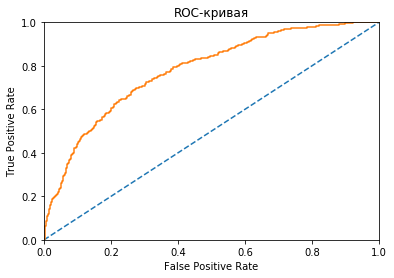

In [67]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def rocCurve(y_val, val_1_prob):
    fpr, tpr, thresholds = roc_curve(y_val, val_1_prob)

    plt.figure()
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
rocCurve(y_val, val_1_prob)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt

val_pred = log_reg.predict(X_val)
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1570
           1       0.59      0.22      0.32       430

    accuracy                           0.80      2000
   macro avg       0.70      0.59      0.60      2000
weighted avg       0.77      0.80      0.76      2000



Из таблицы выше мы можем увидеть как различается F1-score для 0 и для 1. Мы видим, что разница более чем в 2 раза. Это обусловлено большой разницы в "полноте" (Recall). Разница в точности определения классов (Precision) не такая большая.

По графику видно, что наша модель лучше, чем случайная модель. Для того, чтобы понять насколько лучше, посчитаем площадь под кривой - AUC-ROC (значение случайной модели = 0.5). Дополнительно, посмотрим чему равняется F1 мера.

In [69]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

print(f"AUC-ROC = {roc_auc_score(y_val, val_1_prob)}")
print(f"F1 score = {f1_score(y_val, val_pred)}")

AUC-ROC = 0.7791245741371648
F1 score = 0.3163265306122449


##### RandomForestClassifier

In [70]:
from sklearn.ensemble import RandomForestClassifier

#Модель - Случайны лес 
rnd_forest = RandomForestClassifier(n_estimators = 10, random_state=42)
rnd_forest.fit(X_train,y_train)

"""
val_prob - вероятности классов 0 и 1
val_1_prob - вероятность класса 1
val_pred - предсказания по валидационным признакам
"""
val_prob = rnd_forest.predict_proba(X_val)
val_1_prob = val_prob[:,1]
val_pred = rnd_forest.predict(X_val)


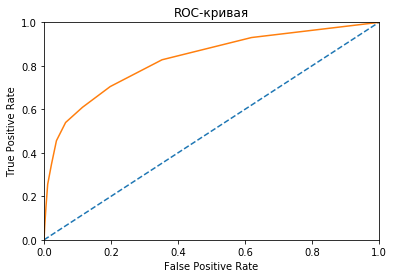

In [71]:
rocCurve(y_val, val_1_prob)

In [72]:
print(f"AUC-ROC = {roc_auc_score(y_val, val_1_prob)}")
print(f"F1 score = {f1_score(y_val, val_pred)}")


val_pred = rnd_forest.predict(X_val)
print(classification_report(y_val, val_pred))

AUC-ROC = 0.8285676196119093
F1 score = 0.5730994152046784
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1570
           1       0.77      0.46      0.57       430

    accuracy                           0.85      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.85      0.84      2000



Значение F1-меры = 0.57,что ниже требуемых 0.59, но значительно выше чем у логистической регрессии.  В это время ROC-AUC = 0.826, что является высоким показателем. 

Видно, что у нас Recall для класса 1 ниже, чем для 0, но почти в 2 раза выше, чем у стандартной логистической регрессии.  

### Краткий вывод

Мы обнаружили, что наблюдается сильный дисбаланс классов. (80 к 20)

Высокий AUC ROC по сравнению с низким F1 означает, что классификатор в настоящее время делает, однако можно найти классовый порог, при котором он хорошо отработает. 


# 3. Борьба с дисбалансом

Для избавления от дисбаланса воспользуемся следующими техниками:
* model(class_weight = "balanced")
* Upsampling

Рассмотрим это для двух моделей.

### class_weight = "balanced"

Попробуем исползовать следующий параметр при обучении. При его использовании модель при обучении будет "штрафовать" более часто встречаемый класс. Попробуем данный параметр для логистической регрессии. 

AUC-ROC = 0.7833491334617094
F1 score = 0.5016501650165016


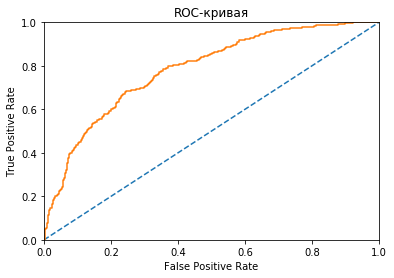

              precision    recall  f1-score   support

           0       0.90      0.70      0.78      1570
           1       0.39      0.71      0.50       430

    accuracy                           0.70      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.70      0.72      2000



In [75]:
model = LogisticRegression(class_weight = 'balanced', random_state = 42, solver ='lbfgs')
model.fit(X_train,y_train)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_val = model.predict(X_val)
print(f"AUC-ROC = {roc_auc_score(y_val, probabilities_one_valid)}")
print(f"F1 score = {f1_score(y_val, predicted_val)}")

rocCurve(y_val, probabilities_one_valid)

print(classification_report(y_val, predicted_val))

Добавление параметра сыграло большую роль для логистической регрессии. Мы видим, что Recall почти выравнился и по этой причине f1 увеличился. В свою очередь AUC-ROC не возрос. 

Попробуем обучить модель RandomForest с данным параметром. 

AUC-ROC = 0.8204636350170346
F1 score = 0.5099236641221374


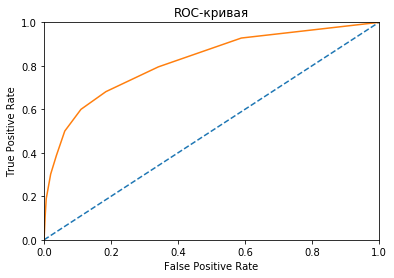

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1570
           1       0.74      0.39      0.51       430

    accuracy                           0.84      2000
   macro avg       0.80      0.68      0.71      2000
weighted avg       0.83      0.84      0.82      2000



In [76]:
model = RandomForestClassifier(class_weight = 'balanced', random_state = 42, n_estimators = 10)
model.fit(X_train,y_train)
probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_val = model.predict(X_val)
print(f"AUC-ROC = {roc_auc_score(y_val, probabilities_one_valid)}")
print(f"F1 score = {f1_score(y_val, predicted_val)}")


rocCurve(y_val, probabilities_one_valid)


print(classification_report(y_val, predicted_val))

Данный способ не сработал для Random Forest. Минимальный f1-score для класса 1 уменьшился (с 0.57 до 51). Попробуем увеличить количество данных в обучающей выборке и сравняем кол-во классов.

### Upsampling

Создадим функцию *upsample* которой будем передавать следующие параметры:
    * признаки
    * цели
    * сколько раз повторить


In [77]:
from sklearn.utils import shuffle

# Функция upsample

def upsample(X,y,repeat):
    X_zeros = X[y==0.0]
    X_ones = X[y==1.0]
    y_zeros = y[y==0.0]
    y_ones = y[y==1.0]
    
    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
    X_upsampled, y_upsampled, random_state = 42)
    
    return X_upsampled, y_upsampled

Передадим нашей функции наши признаки и целевой признак. После, разделим на Train / Val / Test выборки. 

In [78]:
# Увеличиваем в 4 раза.
X_up, y_up = upsample(X, y, 4)

X_train,y_train,X_val,y_val,X_test,y_test = trainValTest(X_up,y_up)

In [79]:
print(f"Class 1 = {(y_up==1).sum()}")
print(f"Class 0 = {(y_up==0).sum()}")

Class 1 = 8148
Class 0 = 7963


В нашей обучающей выборке наблюдается почти полное равновесие между классами. Попробуем теперь обучить наши модели.

AUC-ROC = 0.5698517685308597
F1 score = 0.6174863387978142


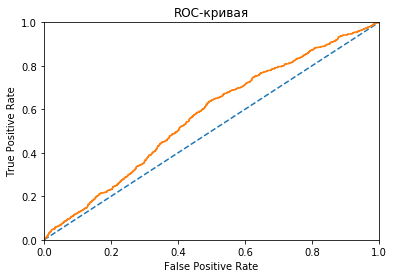

              precision    recall  f1-score   support

           0       0.57      0.44      0.50      1580
           1       0.56      0.69      0.62      1643

    accuracy                           0.57      3223
   macro avg       0.57      0.56      0.56      3223
weighted avg       0.57      0.57      0.56      3223



In [80]:
# Logistic Regression
model = LogisticRegression(random_state = 42, solver ='lbfgs')
model.fit(X_train,y_train)


val_prob = model.predict_proba(X_val)
val_1_prob = val_prob[:, 1]
val_pred = model.predict(X_val)
print(f"AUC-ROC = {roc_auc_score(y_val, val_1_prob)}")
print(f"F1 score = {f1_score(y_val, val_pred)}")

rocCurve(y_val, val_1_prob)

print(classification_report(y_val, val_pred))

Нам удалось получить требуемое значение F1-меры (0.61). В это время AUC-ROC стал 0.58, что говорит о том, что модель работает, но при изменении порога результат может ухудшиться. 

Попробуем обучить простую модель Random Forest и посмотрим на полученный результат. 

AUC-ROC = 0.9739081026526035
F1 score = 0.9327781082688876


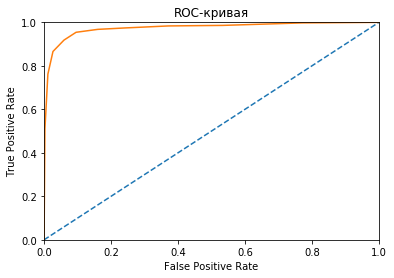

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1580
           1       0.91      0.95      0.93      1643

    accuracy                           0.93      3223
   macro avg       0.93      0.93      0.93      3223
weighted avg       0.93      0.93      0.93      3223



In [81]:
model = RandomForestClassifier(random_state = 42, n_estimators = 10)
model.fit(X_train,y_train)

val_prob = model.predict_proba(X_val)
val_1_prob = val_prob[:, 1]
val_pred = model.predict(X_val)

print(f"AUC-ROC = {roc_auc_score(y_val, val_1_prob)}")
print(f"F1 score = {f1_score(y_val, val_pred)}")

rocCurve(y_val, val_1_prob)

print(classification_report(y_val, val_pred))

Мы получили результат F1-меры = 0.93 и AUC-ROC = 0.97. Классификатор работает хорошо и будет работать для разных порогов.


### Downsampling

Попробуем для балансировки классов уменьшить кол-во предобладающего класса. Для этого создадим функцию `downsample`, в которую будем передавать:

* Признаки
* Целевые признаки
* Доля отрицательных объектов, которые нужно сохранить.


In [82]:
def downsample(features, target, fraction):
    X_zeros = X[y==0.0]
    X_ones = X[y==1.0]
    y_zeros = y[y==0.0]
    y_ones = y[y==1.0]

    X_down = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=42)] + [X_ones])
    y_down = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=42)] + [y_ones])
    
    X_down, y_down = shuffle(
        X_down, y_down, random_state=42)
    
    
    return X_down, y_down

Произведём downsample с коэффициентом 0.25 и разделим на наши выборки.  

In [83]:
X_down, y_down = downsample(X, y, 0.25)

X_train_d, y_train_d, X_val_d, y_val_d, X_test_d, y_test_d = trainValTest(X_down,y_down)
print(f"Class 1 = {(y_down==1).sum()}")
print(f"Class 0 = {(y_down==0).sum()}")

Class 1 = 2037
Class 0 = 1991


У нас получилось по 2 тысячи сэмплов с каждым из классов. Попробуем обучить модель RandomForestClassifier и посмотрим на полученные значения.

AUC-ROC = 0.8241148466801747
F1 score = 0.7250673854447439


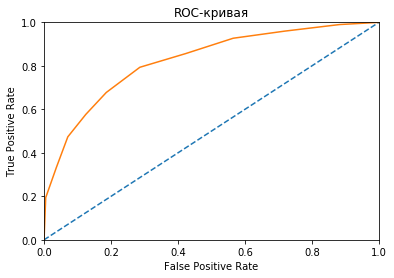

              precision    recall  f1-score   support

           0       0.72      0.81      0.77       409
           1       0.78      0.68      0.73       397

    accuracy                           0.75       806
   macro avg       0.75      0.75      0.75       806
weighted avg       0.75      0.75      0.75       806



In [85]:
rnd_forest = RandomForestClassifier(n_estimators = 10, random_state = 42)
rnd_forest.fit(X_train_d, y_train_d)

val_prob = rnd_forest.predict_proba(X_val_d)
val_1_prob = val_prob[:, 1]
val_pred = rnd_forest.predict(X_val_d)

print(f"AUC-ROC = {roc_auc_score(y_val_d, val_1_prob)}")
print(f"F1 score = {f1_score(y_val_d, val_pred)}")

rocCurve(y_val_d, val_1_prob)

print(classification_report(y_val_d, val_pred))

У нас получилось получить значение F1 меры = 0.725, а ROC-AUC = 0.824. Это хорошие показатели. Модель соответствует требованиям, но с использованием *upsample* у нас получилось достичь лучшего результата. Для дальнейшей работы используем этот метод. 



Попробуем улучшить результат для F1 меры через подбор параметров силами RandomizedSearchCV.

Используем следующее распределение значений:
* `n_estimators = от 100 до 1000 (7 значений)`
* `max_features = ['auto', 'sqrt']`
* `max_depth = от 1 до 30 (5 значений) + дополнительно не будем ограничивать глубину. `

In [86]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# RandomizedSearchCV

rnd_forest = RandomForestClassifier(random_state = 42)

# Кол-во деревьев  в лесу
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 7)]

# Количество признаков 
max_features = ['auto', 'sqrt']

# Максимальная глубина деревьев
max_depth = [int(x) for x in np.linspace(1, 30, num = 5)]
max_depth.append(None)

# Сохраняем параметры в dict
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}


random_grid

{'n_estimators': [100, 250, 400, 550, 700, 850, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [1, 8, 15, 22, 30, None]}

In [87]:
%%time
# Начинаем поиск. 

"""
Поиск будем производить со следующими параметрами:
Модель - RandomForest
Параметры - random_grid
CV - 3
n_iter (кол-во итераций) - 50. Если параметров меньше 100, то по всем доступным.
Оценка - по F1
"""

rf_random = RandomizedSearchCV(estimator = rnd_forest, 
                               param_distributions = random_grid, 
                               cv = 3,  verbose = 1, n_iter= 50,
                               random_state=42, n_jobs = -1, scoring= 'f1')

rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 11.2min finished


CPU times: user 11min 7s, sys: 1.61 s, total: 11min 8s
Wall time: 11min 10s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [88]:
rf_random.best_params_

{'n_estimators': 100, 'max_features': 'auto', 'max_depth': None}

In [90]:
model = RandomForestClassifier(random_state = 42, n_estimators = 100, max_features = 'auto', max_depth = None)
model.fit(X_train,y_train)

probabilities_valid = model.predict_proba(X_val)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_val = model.predict(X_val)

print(f"AUC-ROC = {roc_auc_score(y_val, probabilities_one_valid)}")
print(f"F1 score = {f1_score(y_val, predicted_val)}")

print(classification_report(y_val, predicted_val))

AUC-ROC = 0.9838545960230205
F1 score = 0.9391971664698937
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1580
           1       0.91      0.97      0.94      1643

    accuracy                           0.94      3223
   macro avg       0.94      0.94      0.94      3223
weighted avg       0.94      0.94      0.94      3223



### Краткий вывод

При балансировке классов были выбраны три метода:

    * Параметр class_weights = "Balanced"
    * Upsampling 
    * Downsampling
    
Балансировка через параметр модели хорошо поднял величину F1 меры для логистической регрессии, но не сработал для RandomForestClassifier. 

При уменьшении количества сэмплов доминирующего класса качество также возросло:

* AUC-ROC = 0.824
* F1 Score = 0.725 

После применения метода увеличения кол-ва наименьшего из классов, нам удалось достичь следующих значений:

* AUC-ROC = 0.97
* F1 Score = 0.93

Это высокие показатели говорят нам о том, что наша модель хорошо работает и будет актуальна для разных порогов. 

Был проведён подбор гиперпараметров и после нахождения оптимальных значений показатели наши метрики ещё возросли:

* AUC-ROC = 0.987
* F1 Score = 0.939

Это очень высокий показатель. Проведём тестирование полученной модели на тестовых данных.

# 4. Тестирование модели

In [92]:
fin_model = RandomForestClassifier(n_estimators = 100, max_features='auto', max_depth = None, random_state = 42)
fin_model.fit(X_train, y_train)

test_prob = fin_model.predict_proba(X_test)
test_1_prob = test_prob[:,1]

test_pred = fin_model.predict(X_test)

print(f"AUC-ROC = {roc_auc_score(y_test, test_1_prob)}")
print(f"F1 score = {f1_score(y_test, test_pred)}")

print(classification_report(y_test, test_pred))

AUC-ROC = 0.9840838079818044
F1 score = 0.9425219941348973
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      1575
           1       0.91      0.98      0.94      1647

    accuracy                           0.94      3222
   macro avg       0.94      0.94      0.94      3222
weighted avg       0.94      0.94      0.94      3222



Модель на тестовых данных очень хорошо отработала и полученное качество не сильно отличается, от полученного на валидационной выборке. 

# 5. Выводы

Перед нами стояла задача построение модели прогнозирования ухода клиента из банка в ближайшее время. Для этой задачи у нас имеется таблица, состоящая из признаков (к примеру, кредитная оценка, кол-во недвижимости) и целевой признак - Exited (ушёл клиент или нет).

Признаком успешной модели является значение F1-меры на тестовой выборке > 0.59.

В процессе работы с данными выполнена:

* Проверка на пропущенные значения и их замена на медианные.
* Проведена стандартизация количественных признаков методом RobustScaler()
* Деление выборки на обучающую, валидационную и тестовую в соотношении 60 / 20 / 20

Далее был проведён анализ классов и найден сильный дисбаланс (80% к 20%). Полученные модели не удовлетворяли требуемым значениями и F1-score был менее 0.59. Для дальнейшей работы необходимо было произвести балансировку классов. 

Для балансировки были выбраны два метода:
* Путём добавления к модели параметра `class_weight = 'balanced'`
* Уменьшением кол-ва доминирующего из классов (функция `downsample`)
* Увеличением кол-ва меньшего из классов (функция `upsample`)


Последний из методов позволил нам на модели Random Forest достичь значения F1 меры в 0.94,а AUC-ROC ~ 0.98

Модель была протеститрована на тестовой выборке и полученные значения метрик удовлетворяют требуемым.  